In [16]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform
from scipy import ndimage
import skimage.color
import skimage.io
import cv2
from google.colab.patches import cv2_imshow
from sklearn.decomposition import PCA

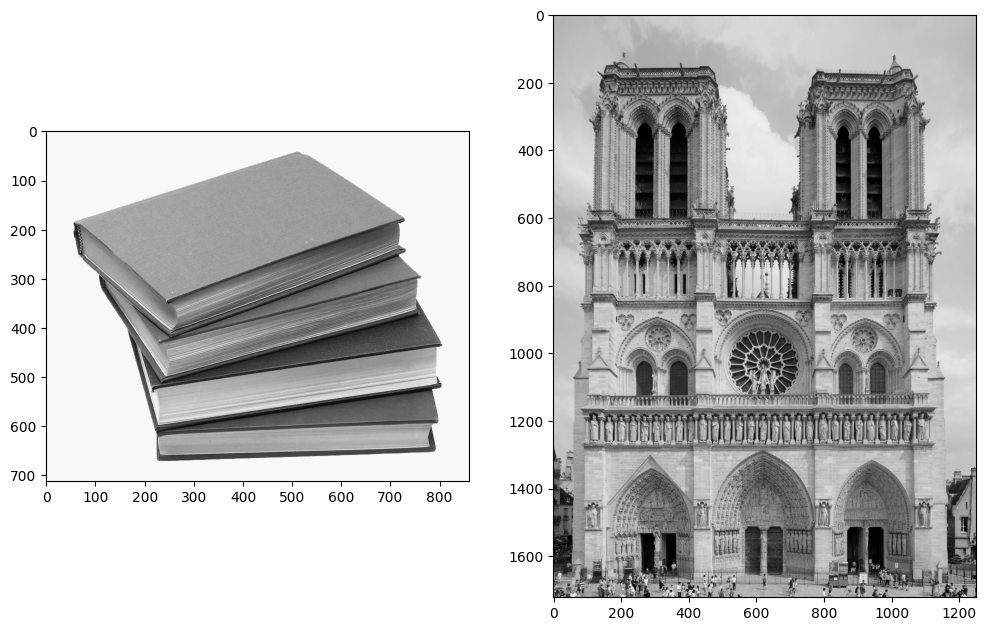

In [17]:
books = skimage.color.rgb2gray(skimage.io.imread('/content/img2.png')[:,:,:3])
building = skimage.color.rgb2gray(skimage.io.imread('/content/img1.png')[:,:,:3])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(building,cmap='gray')
plt.show()

In [18]:
# global values of sigma and k
sigma_int = 1.6
k = 2 ** (1. / 5)

In [19]:
# function for calculating no of octaves possible
def numberOfOctaves(img_shape):

    return int(round(np.log(min(img_shape)) / np.log(2) - 1))

In [20]:
# function for finding all extremas
def find_extremas(dog_lower,dog_current,dog_upper,image_shape,k,octave_no,final_keypoints):
   # 3 layers are stacked
   stacked_layers = np.stack([dog_lower, dog_current, dog_upper])

   # true if (i,j) is an extremum in it's neighbourhood
   l_maxima = (stacked_layers ==  ndimage.maximum_filter(stacked_layers, size=(3, 3, 3)))
   l_minima = (stacked_layers == ndimage.minimum_filter(stacked_layers, size=(3, 3, 3)))

   # locating all keypoints and setting a threshold so that low contrast points are neglected(done to reduce keypoints)
   for i in range(1,image_shape[0]-1):
    for j in range(1,image_shape[1]-1):
      if (l_maxima[1][i][j] or l_minima[1][i][j]) and abs(dog_current[i][j]) > 2:
        final_keypoints.append([(i,j),(k,octave_no)])


In [21]:
# function for creating diff of gaussians
def extremas_octave(image,final_keypoints,sigma_int,octave_no,num_interval):
  # factor for octave
  octave_coeff = 2 ** octave_no
  #no of images per ocatve
  num_images_per_octave = num_interval + 3

  # gaussian blurred images of an octave
  gaussian_blur = []
  for i in range(num_images_per_octave):
    gaussian_blur.append(ndimage.gaussian_filter(image,sigma_int * (k**i) * octave_coeff)*255)

  # Diff of gaussians
  diff_gaussian = []
  for i in range(len(gaussian_blur)-1):
    diff_gaussian.append(gaussian_blur[i+1] - gaussian_blur[i])

  #find extremas
  for i in range(1,len(diff_gaussian)-1):
    lower_layer = diff_gaussian[i-1].copy()
    current_layer = diff_gaussian[i].copy()
    upper_layer = diff_gaussian[i+1].copy()
    find_extremas(lower_layer,current_layer,upper_layer,image.shape,i,octave_no,final_keypoints)
  return gaussian_blur


In [22]:
# orientation assignment
def orientation(gaussian_image_pyramid,final_keypoints):
  # set of all (scale,ocatve no) where keypoint is detected
  unique_keypoints_scales = set([x[1] for x in final_keypoints])

  # map from scale,octave --> location of keypoint
  keypoint_map = {scale_octave: [] for scale_octave in unique_keypoints_scales}
  for ele in final_keypoints:
    keypoint_map[ele[1]].append(ele[0])

  for scale_octave in unique_keypoints_scales:
    locations = keypoint_map[scale_octave]
    gaussian_image = gaussian_image_pyramid[int(scale_octave[1])][int(scale_octave[0])]
    dx = ndimage.sobel(gaussian_image, axis=0)  # dx in x direction
    dy = ndimage.sobel(gaussian_image, axis=1)  # dy in y direction
    magnitude = np.sqrt(dx**2 + dy**2)  # gradient magnitude
    orientation = np.arctan2(dy, dx) * 180 / np.pi % 360  # gradient orientation

    radius = int(round(3 * (k**scale_octave[0])))  # radius of the neighborhood

    for (p, q) in locations:
      histogram = np.zeros(36, dtype=np.float32)
      for i in range(max(p - radius, 0), min(p + radius + 1, gaussian_image.shape[0])):
        for j in range(max(q - radius, 0), min(q + radius + 1, gaussian_image.shape[1])):
          bin = int(np.round(orientation[i, j] / 10))  # orientation bin
          histogram[bin % 36] += magnitude[i, j]  # Increment the count for this bin

      max_bin_index = np.argmax(histogram)
      orientation_angle = 5 + max_bin_index * 10

      for ele in final_keypoints:
        if ele[0] == (p, q) and ele[1] == scale_octave:
          ele.append((orientation_angle,magnitude[p][q]))

In [23]:
def generateDescriptors(keypoints, gaussian_image_pyramid):
    covariance_matrix = []
    # Loop through keypoints
    for keypoint in keypoints:
        layer, octave = keypoint[1]
        kp_x, kp_y = keypoint[0]

        #gaussian Image
        gaussian_image = gaussian_image_pyramid[octave][layer]

        # Calculate patch half-size
        half_patch_size = 20

        # Ensure patch boundaries are within image bounds
        if ((kp_x - half_patch_size) < 0 or (kp_y - half_patch_size) < 0
                or (kp_x + half_patch_size) >= gaussian_image.shape[1]
                or (kp_y + half_patch_size) >= gaussian_image.shape[0]):
            continue

        # Define patch corners
        top_left = (int(kp_x - half_patch_size), int(kp_y - half_patch_size))
        bottom_right = (int(kp_x + half_patch_size), int(kp_y + half_patch_size))

        # Extract patch
        patch = gaussian_image[top_left[1]:bottom_right[1]+1, top_left[0]:bottom_right[0]+1]

        # Rotate patch
        rotated_patch = ndimage.rotate(patch, -keypoint[2][0])

        # gradients of patch
        dx = np.array(ndimage.sobel(patch, axis=0))
        dy = np.array(ndimage.sobel(patch, axis=1))

        # extracting 39X39 from dx,dy
        center_x = dx.shape[0] // 2
        center_y = dy.shape[1] // 2
        half_size = 19  # half of the size of the square (39x39)

        # Extract the central square
        dx_square = dx[center_x - half_size: center_x + half_size + 1,
                              center_y - half_size: center_y + half_size + 1]

        dy_square = dy[center_x - half_size: center_x + half_size + 1,
                              center_y - half_size: center_y + half_size + 1]

        # Flatten the central square back into a 1D array if needed
        dx_new = dx_square.flatten()
        dy_new = dy_square.flatten()

        concatenated_descriptor = np.concatenate((dx_new, dy_new))

        # Normalize the descriptor
        normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)

        # Append normalized descriptor to covariance matrix
        covariance_matrix.append(normalized_des)

    # Convert covariance matrix to numpy array
    covariance_matrix = np.array(covariance_matrix)
    covariance_matrix = covariance_matrix[~np.isnan(covariance_matrix).any(axis=1)]

    # Perform PCA
    pca = PCA(n_components=64)

    # Fit PCA to the descriptors
    pca.fit(covariance_matrix)

    # Transform descriptors using PCA
    descriptors_pca = pca.transform(covariance_matrix)

    return descriptors_pca


# MAIN CALLING FUNCTION AND EXCETUING ALL STEPS OF PCA SIFT

In [24]:
def extract_keypoints_and_descriptors(image):
  final_keypoints = []
  gaussian_image_pyramid = []

  #Step 1: Extracting Keypoints
  for octave_no in range(1): # instead of random octaves u can use num_of_octaves(image.shape) can be used to run through all octaves
    gaussian_image_pyramid.append(extremas_octave(image,final_keypoints,sigma_int,octave_no,3))

  # Step 3: Orientation Assignment
  orientation(gaussian_image_pyramid,final_keypoints)

  # Step 4:Extracting Descriptors And applying PCA SIFT
  descriptors = generateDescriptors(final_keypoints,gaussian_image_pyramid)
  return final_keypoints,descriptors


In [25]:
def keypoint_mapping(image, final_keypoints,i):
    # Original image
    plt.subplot(1, 2, i)
    plt.imshow(image, cmap='gray')

    # Plot keypoints
    for keypoint in final_keypoints:
        pt = keypoint[0]
        octave = keypoint[1][1]
        plt.plot(pt[1], pt[0], 'ro', markersize=1)  # Plot red keypoints

In [26]:
dict = {'original_books':books,
        'original_building':building,
        'rotate_buildings':ndimage.rotate(building,90),
        'rotate_books':ndimage.rotate(books,90),
        'blur_building':cv2.GaussianBlur(building,(3,3),0),
        'blur_books':cv2.GaussianBlur(books,(3,3),0),
        'scale_up_building':cv2.resize(building, None, fx=1.5, fy=1.5),
        'scale_up_books':cv2.resize(books, None, fx=1.5, fy=1.5),
        'scale_down_building':cv2.resize(building, None, fx=.5, fy=.5),
        'scale_down_books':cv2.resize(books, None, fx=.5, fy=.5)}

**COMPARISION 1: ORGINAL BUILDING**

Original Building
Keypoints =  5847


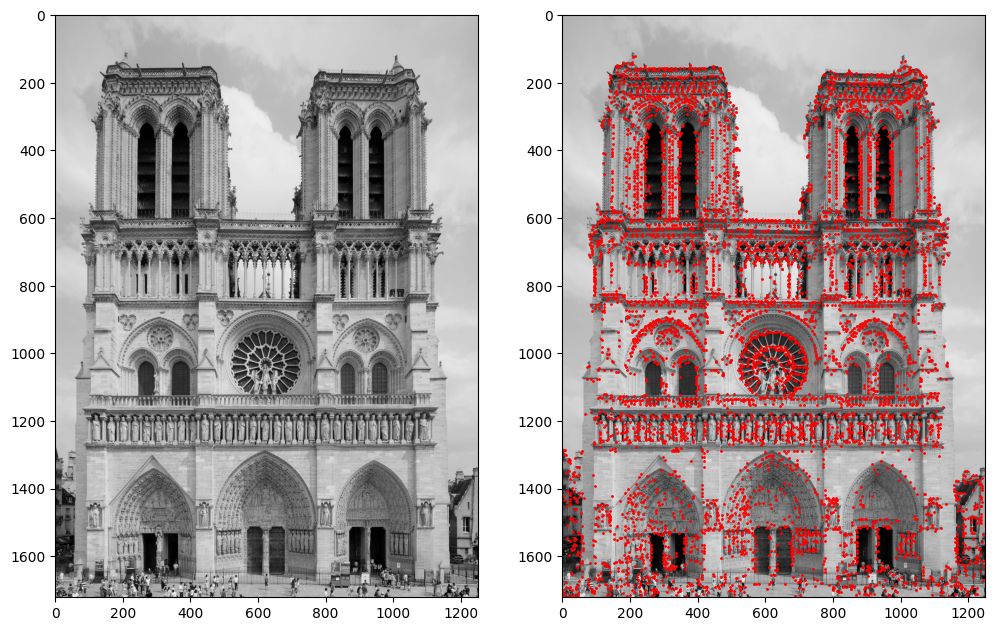

In [27]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(building)
print("Original Building")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(building,cmap='gray')
keypoint_mapping(building.copy(),final_keypoints,2)

**COMPARISION 2: ORGINAL BOOKS**

<ipython-input-23-a7e95bbf9818>:53: RuntimeWarning: invalid value encountered in divide
  normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)


Original Books
Keypoints =  1039


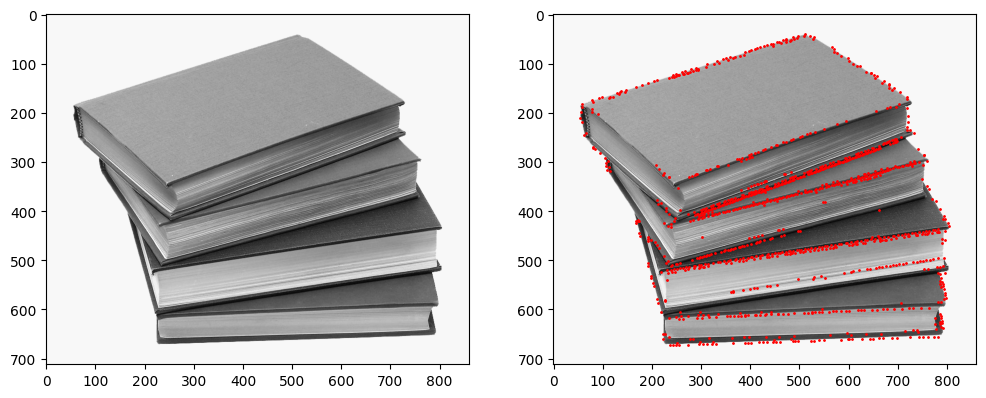

In [28]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(books)
print("Original Books")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(books,cmap='gray')
keypoint_mapping(books.copy(),final_keypoints,2)


**COMPARISION 3: ROTATED BUILDING**

Rotated Building
Keypoints =  5847


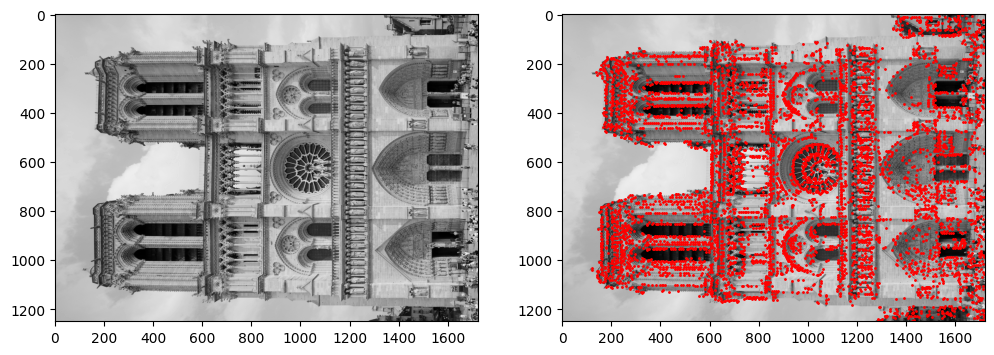

In [29]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['rotate_buildings'])
print("Rotated Building")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['rotate_buildings'],cmap='gray')
keypoint_mapping(dict['rotate_buildings'].copy(),final_keypoints,2)

**COMPARISION 4: ROTATED BOOKS**

<ipython-input-23-a7e95bbf9818>:53: RuntimeWarning: invalid value encountered in divide
  normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)


Rotated Books
Keypoints =  1039


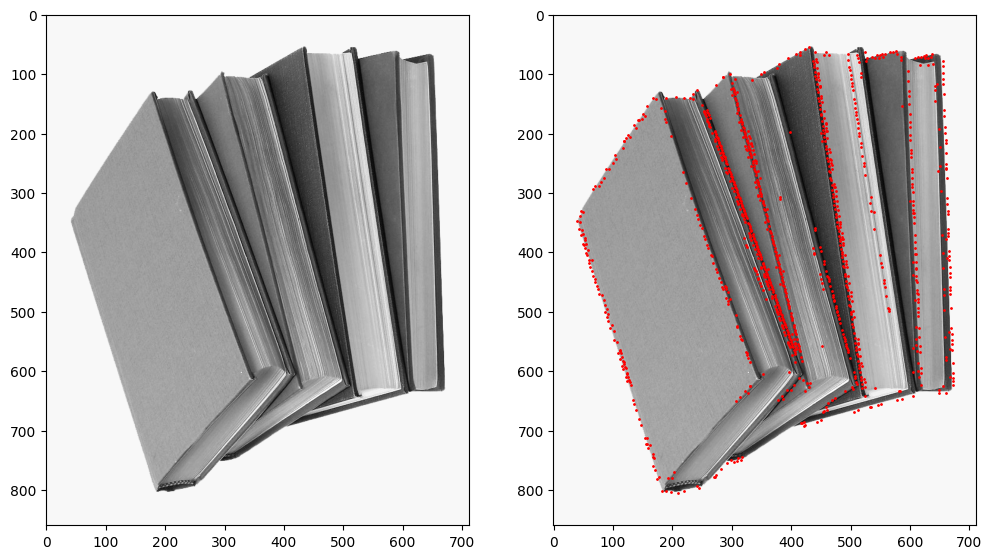

In [30]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['rotate_books'])
print("Rotated Books")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['rotate_books'],cmap='gray')
keypoint_mapping(dict['rotate_books'].copy(),final_keypoints,2)

**COMPARISION 5.1: SCALED UP BUILDING**

Scaled Up Building
Keypoints =  12015


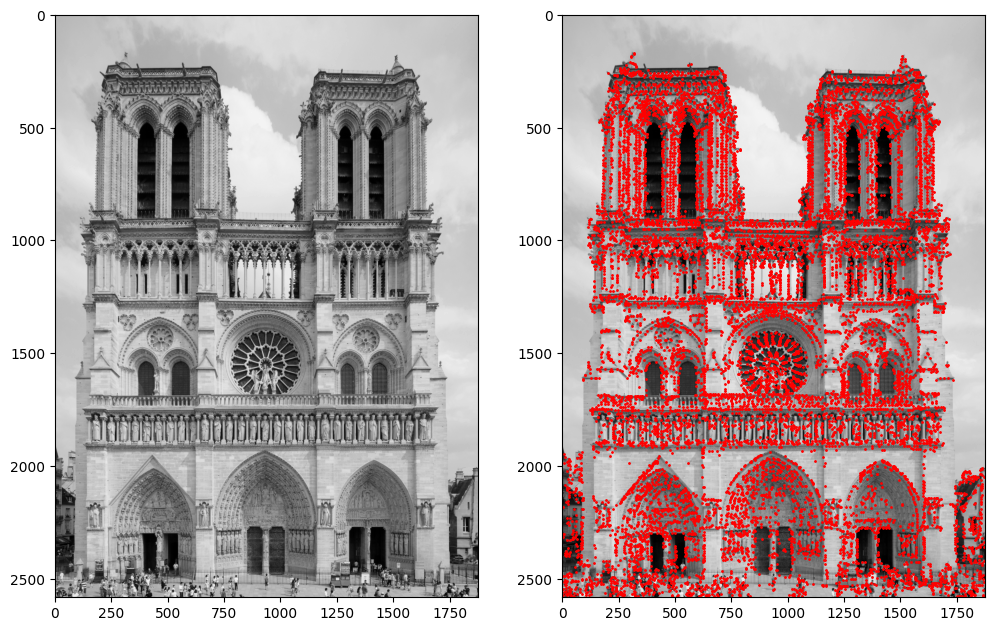

In [31]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['scale_up_building'])
print("Scaled Up Building")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['scale_up_building'],cmap='gray')
keypoint_mapping(dict['scale_up_building'].copy(),final_keypoints,2)

**COMPARISION 5.2: SCALED UP BOOKS**

<ipython-input-23-a7e95bbf9818>:53: RuntimeWarning: invalid value encountered in divide
  normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)


Scaled Up Books
Keypoints =  1097


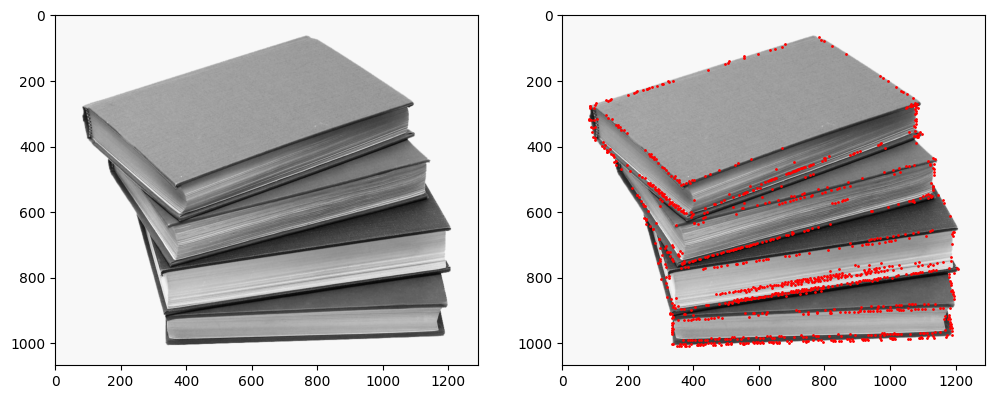

In [32]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['scale_up_books'])
print("Scaled Up Books")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['scale_up_books'],cmap='gray')
keypoint_mapping(dict['scale_up_books'].copy(),final_keypoints,2)

**COMPARISION 6.1 : SCALED DOWN BUILDING**


Scaled Down Building
Keypoints =  1580


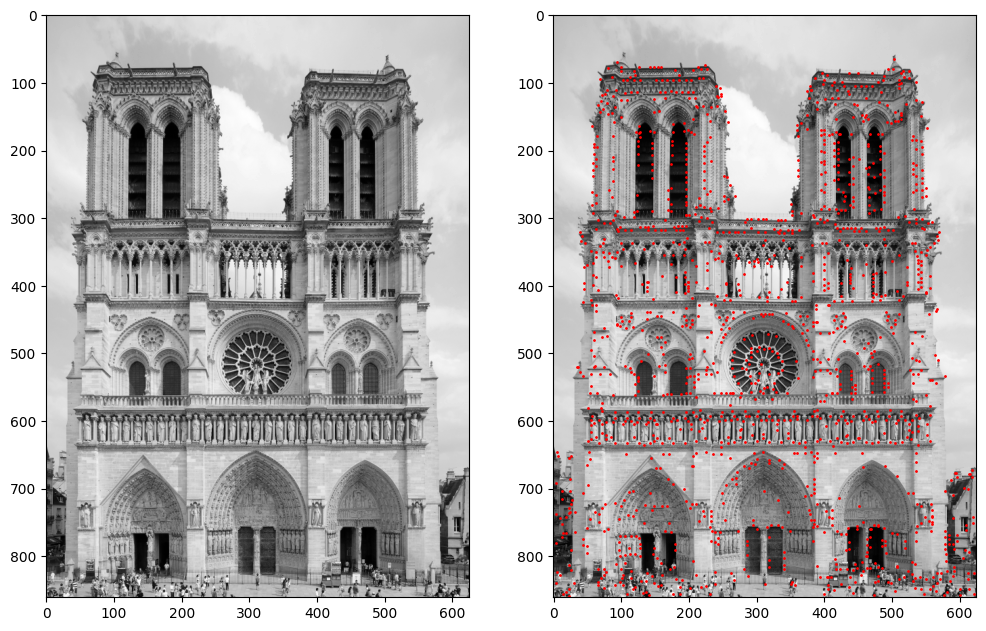

In [33]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['scale_down_building'])
print("Scaled Down Building")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['scale_down_building'],cmap='gray')
keypoint_mapping(dict['scale_down_building'].copy(),final_keypoints,2)

**COMPARISION 6.2: SCALED DOWN BOOKS**




<ipython-input-23-a7e95bbf9818>:53: RuntimeWarning: invalid value encountered in divide
  normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)


Scaled Down Books
Keypoints =  287


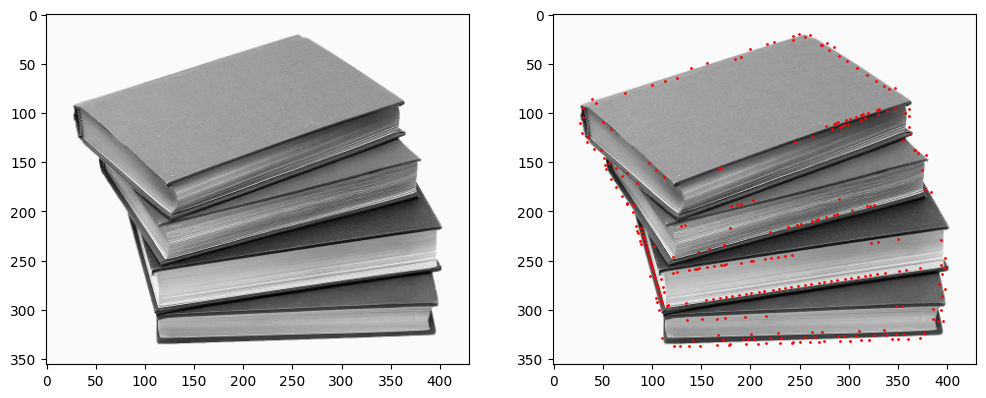

In [34]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['scale_down_books'])
print("Scaled Down Books")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['scale_down_books'],cmap='gray')
keypoint_mapping(dict['scale_down_books'].copy(),final_keypoints,2)

**COMPARISION 7: GAUSSIAN BLUR BUILDING**

Gaussian blurred Building
Keypoints =  6331


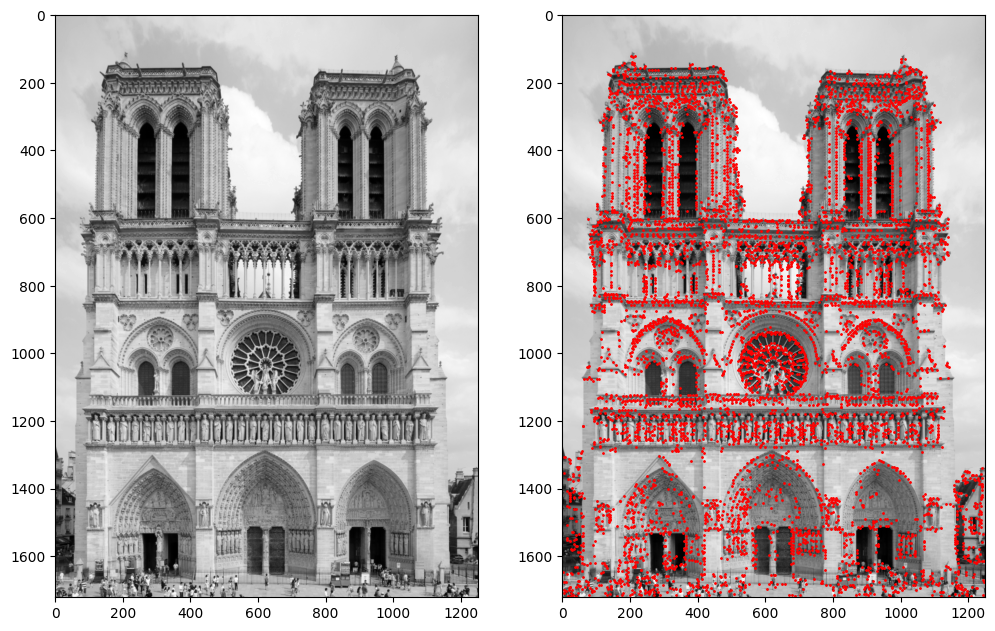

In [35]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['blur_building'])
print("Gaussian blurred Building")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['blur_building'],cmap='gray')
keypoint_mapping(dict['blur_building'].copy(),final_keypoints,2)

**COMPARISION 8: GAUSSIAN BLUR BOOKS**

<ipython-input-23-a7e95bbf9818>:53: RuntimeWarning: invalid value encountered in divide
  normalized_des = concatenated_descriptor / np.linalg.norm(concatenated_descriptor)


Gaussian blurred Books
Keypoints =  910


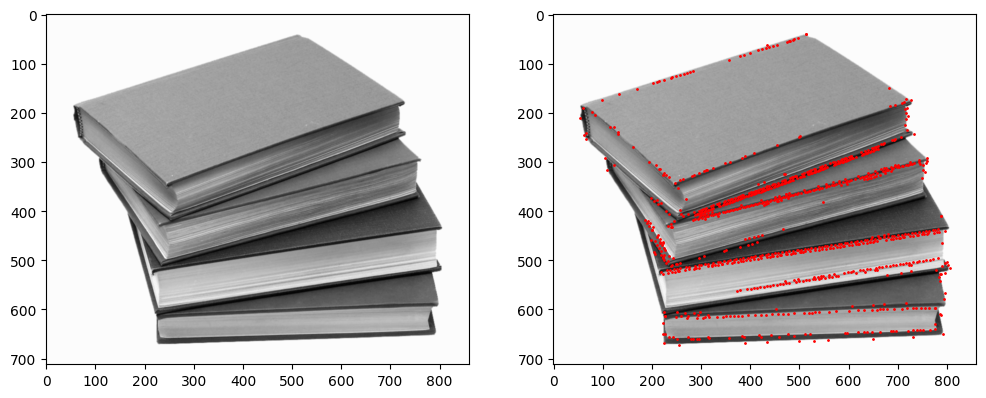

In [36]:
final_keypoints,descriptors = extract_keypoints_and_descriptors(dict['blur_books'])
print("Gaussian blurred Books")
print("Keypoints = ",len(final_keypoints))
# print("Descriptors = ",descriptors.shape[0])
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(dict['blur_books'],cmap='gray')
keypoint_mapping(dict['blur_books'].copy(),final_keypoints,2)